In [20]:
import os 

os.chdir("/home/hamza-arain/Documents/code/recmmendation")

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations
from datetime import datetime
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

pd.options.mode.chained_assignment = None

plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = 1

In [22]:
df = pd.read_csv("data/online_retail_final.csv")
# df = pd.read_csv("data/data.csv", encoding="ISO-8859-1")


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
display(df.head())
print(df.shape)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


(404090, 9)


<a id="section-one"></a>

## 1) Basic Data Analysis

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404090 entries, 0 to 404089
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    404090 non-null  object        
 1   StockCode    404090 non-null  object        
 2   Description  404090 non-null  object        
 3   Quantity     404090 non-null  int64         
 4   InvoiceDate  404090 non-null  datetime64[ns]
 5   UnitPrice    404090 non-null  float64       
 6   CustomerID   404090 non-null  float64       
 7   Country      404090 non-null  object        
 8   TotalPrice   404090 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.7+ MB


In [24]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,404090.000000,404090,404090.000000,404090.000000,404090.000000
mean,9.328724,2011-07-10 17:17:03.838402304,3.474446,15286.660407,16.854000
min,-80995.000000,2010-12-01 08:26:00,0.001000,12346.000000,-168469.600000
25%,2.000000,2011-04-06 14:53:00,1.250000,13954.000000,4.200000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000,10.500000
75%,12.000000,2011-10-20 13:24:00,3.750000,16791.000000,18.720000
max,147.000000,2011-12-09 12:50:00,38970.000000,18287.000000,38970.000000
std,174.542052,NaN,69.549369,1712.698993,308.731606


/tmp/ipykernel_20731/1658731281.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h",


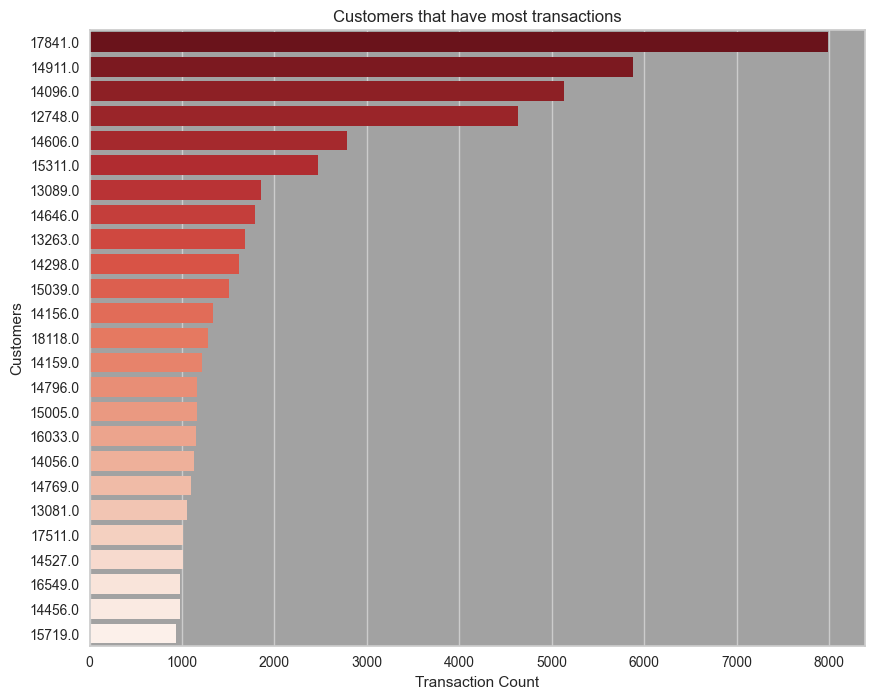

In [25]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "Reds_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

/tmp/ipykernel_20731/469778379.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h",


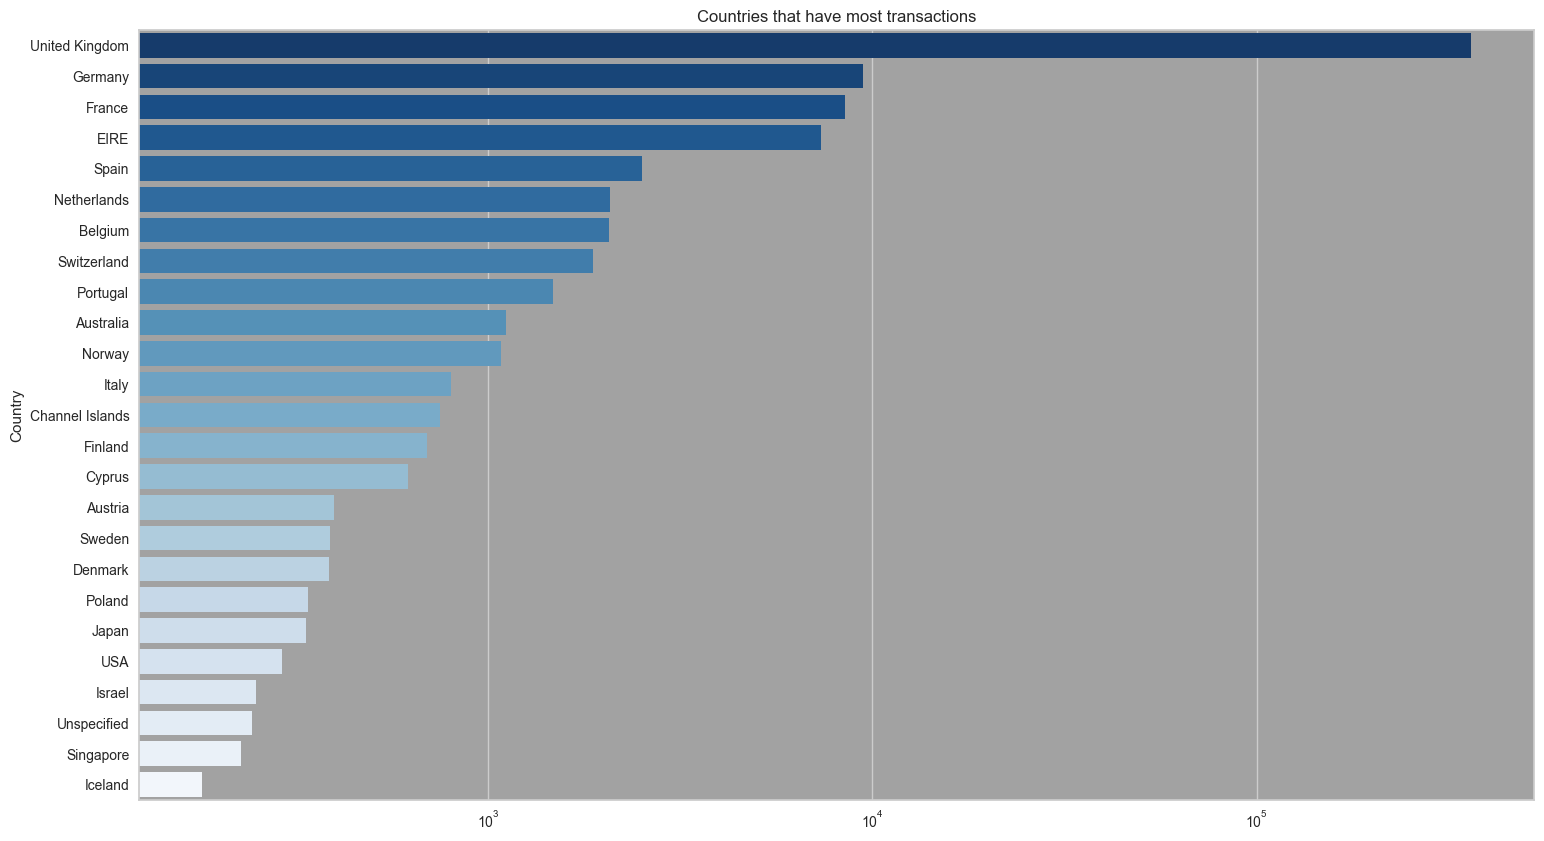

In [26]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Blues_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

[take me to the top](#section-top)

<a id="section-two"></a>

## 2) Cohort Analysis

Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time or is only appearing to improve because of growth.

Cohort analysis is a subset of behavioral analytics that takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span.

Generally, we have three type of cohort analysis:

   - **Time cohorts** or **Acquisition cohorts**: Groups are divided by first activity.
   - **Behavior cohorts** or **Segment-Based cohorts**: Groups are divided by their behaivors and actions about your service.
   - **Size cohorts**: Size-based cohorts refer to the various sizes of customers who purchase a company’s products or services.


In [27]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))
print("Time difference is: {}".format(df.InvoiceDate.max() - df.InvoiceDate.min()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00
Time difference is: 373 days 04:24:00


Our dataset contains invoice records for more than one year.<br> 
Let's apply cohort analysis. We can create monthly cohorts.

In [28]:
def get_month(x):
    """Apply invoice of 1st month"""
    return dt.datetime(x.year, x.month, 1) 

def get_dates(df, col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)
df["CohortMonth"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min")


invoice_year, invoice_month, invoice_day = get_dates(df, "InvoiceMonth")
cohort_year, cohort_month, cohort_day = get_dates(df, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df["CohortIndex"] = 12 * year_diff + month_diff + 1

cohort_data = df.groupby(["CohortIndex", "CohortMonth"])["CustomerID"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index = "CohortMonth", columns = "CohortIndex", values = "CustomerID")
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


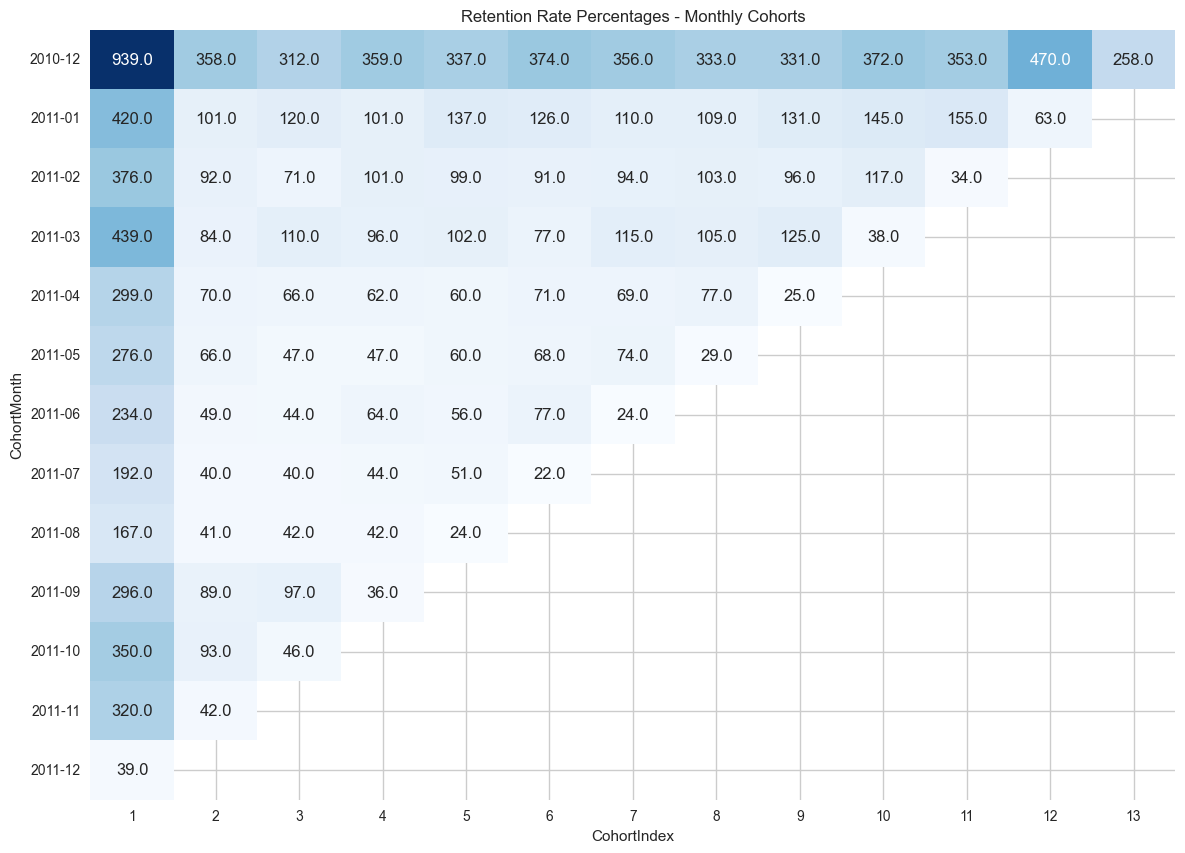

In [29]:
plt.rcParams["axes.facecolor"] = "white"
fig, ax = plt.subplots(figsize = (14, 10))
cohort_pivot.index = cohort_pivot.index.strftime("%Y-%m")

sns.heatmap(cohort_pivot, cmap = "Blues", annot = True, fmt = "2", annot_kws = {"fontsize": 12}, cbar = False, ax = ax)

plt.title("Retention Rate Percentages - Monthly Cohorts")
plt.yticks(rotation = 0)
plt.show()

The December 2010 cohort started with 939 users<br>
Next 358, 312, 359, 337, 374, 356, 333, 331, 372, 353, 470 and 258 cutomers repeated respectively month by month.

<a id="section-two-one"></a>

## 2.1) Retention Rate

![](https://images.ctfassets.net/vrkkgjbn4fsk/7KUaWGQ9IJvf85OheLucgk/e03a27e5c68cc317b38dda354fee504d/how_to_calculate_user_retention_rate)


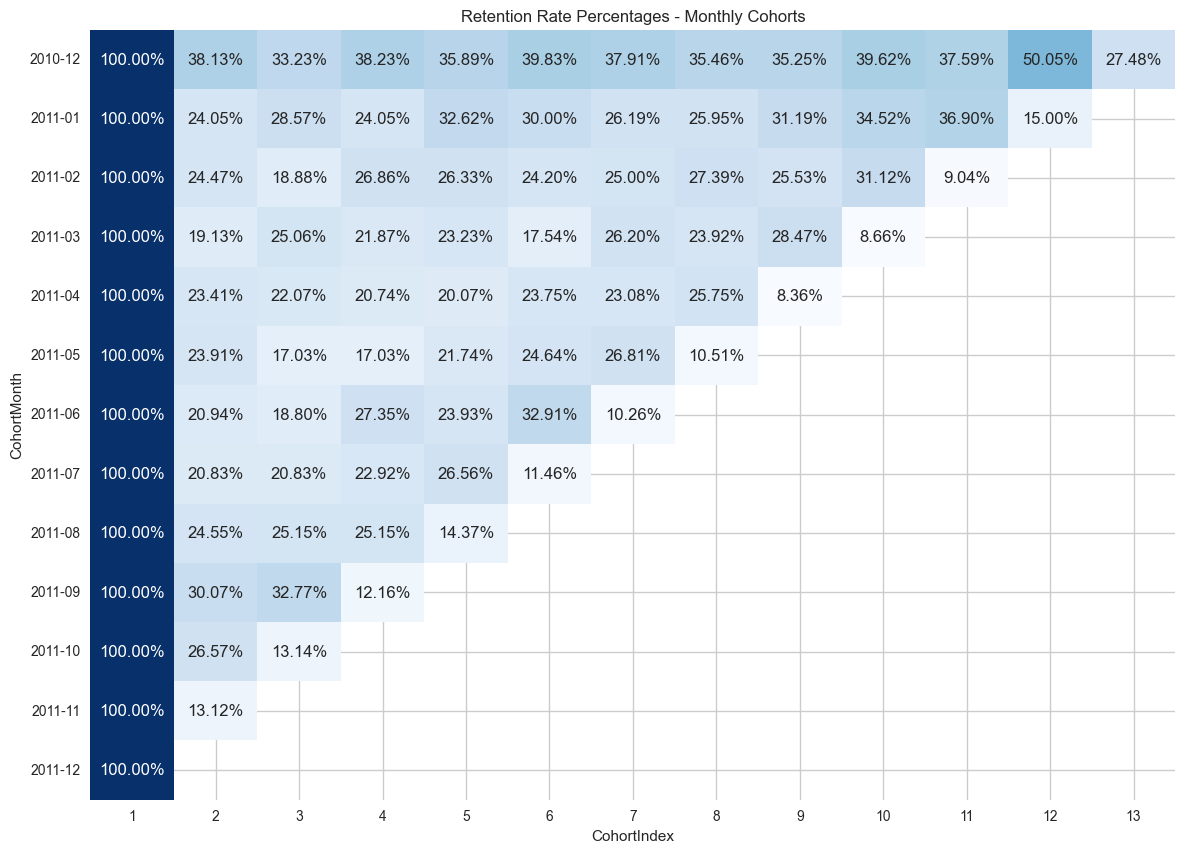

In [30]:
cohort_sizes = cohort_pivot.iloc[:, 0]

retention = cohort_pivot.divide(cohort_sizes, axis = 0)
# retention.index = retention.index.strftime("%Y-%m")

plt.rcParams["axes.facecolor"] = "white"
fig, ax = plt.subplots(figsize = (14, 10))

sns.heatmap(retention, cmap = "Blues", annot = True, fmt = ".2%", annot_kws = {"fontsize": 12}, cbar = False, ax = ax)

plt.title("Retention Rate Percentages - Monthly Cohorts")
plt.yticks(rotation = 0)
plt.show()

27.48% of customers that made their first shopping in December 2010, use this company in 13th month.

In [31]:
customer_per_month = df.groupby("CohortMonth")["CustomerID"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([4347, 4308, 3988, 3638, 3342, 3175, 2983, 2749, 2473, 2174, 1735,
       1359,  939])

In [32]:
customer_in_month = df.groupby("CohortIndex")["CustomerID"].nunique()
customer_in_month

CohortIndex
1     4347
2     1125
3      995
4      952
5      926
6      906
7      842
8      756
9      708
10     672
11     542
12     533
13     258
Name: CustomerID, dtype: int64

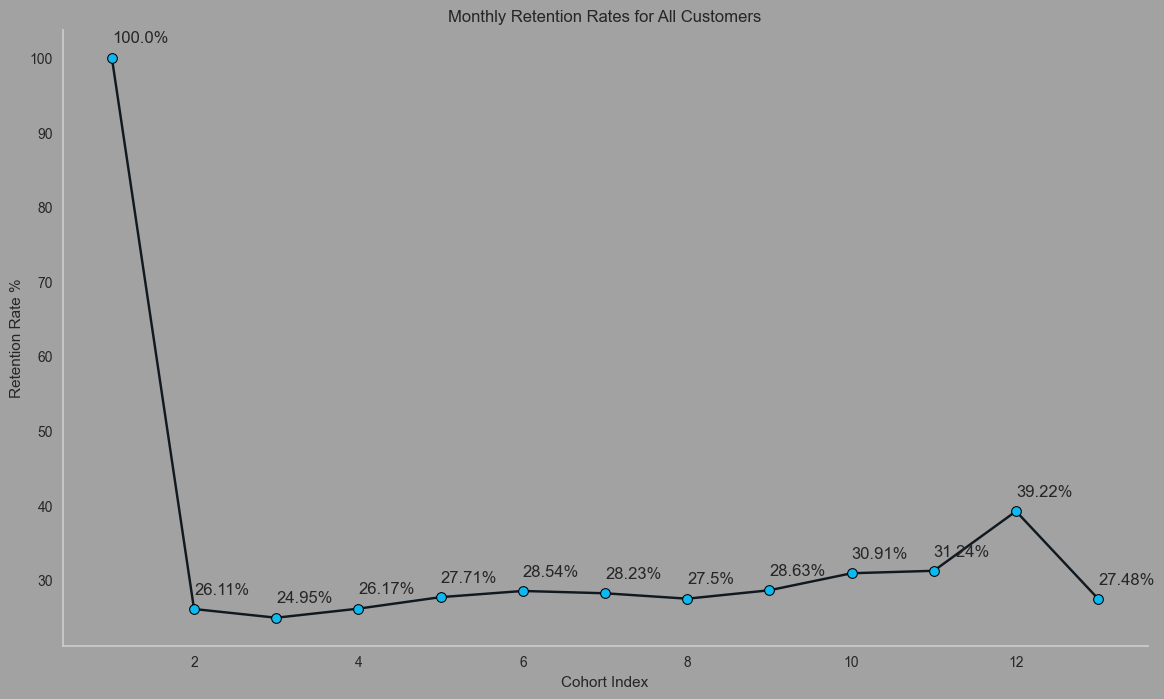

In [33]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (14, 8), facecolor = "#A2A2A2")
ax.grid(False)
x = customer_in_month.index
y = 100*(customer_in_month / customers)

sns.lineplot(x = x, y = y,  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

for x, y in zip(x, y):
    plt.text(x, y + 2, s = str(round(y, 2)) + "%")

plt.xlabel("Cohort Index")
plt.ylabel("Retention Rate %")
plt.title("Monthly Retention Rates for All Customers")
sns.despine()
plt.show()

In [34]:
monthly_customer_price_df = df.groupby("InvoiceMonth").agg({"TotalPrice": "sum",
                                                            "CustomerID": "nunique"})
monthly_customer_price_df

,TotalPrice,CustomerID
InvoiceMonth,,
2010-12-01,474273.700,939
2011-01-01,319657.320,778
2011-02-01,382469.300,789
2011-03-01,503430.010,1010
2011-04-01,363407.161,892
2011-05-01,571402.640,1068
2011-06-01,500798.100,1043
2011-07-01,481514.941,986
2011-08-01,494996.790,969


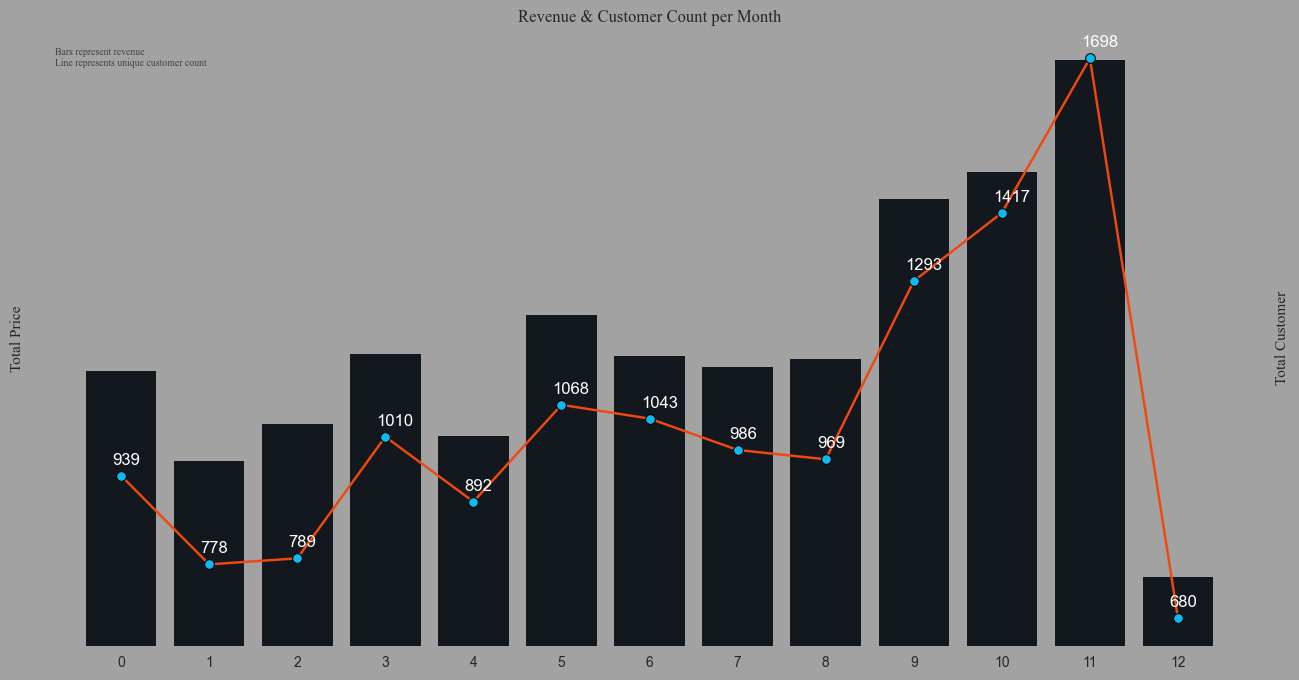

In [35]:

fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.TotalPrice, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.CustomerID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "Times New Roman")
ax.set_ylabel("Total Price", fontname = "Times New Roman")
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman")
ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", 
        fontsize = 7, alpha = 0.8, fontname = "Times New Roman")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.CustomerID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

Probably, Thanksgiving, Black Friday and Christmas causes it. There are lots of special day at the end of year.

[take me to the top](#section-top)

<a id="section-three"></a>

## 3) Pareto Principle

The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes (the “vital few”).

Other names for this principle are the 80/20 rule, the law of the vital few, or the principle of factor sparsity.

**Lets implement Pareto's 80-20 rule to our dataset**. We have two hypothesis:

    1) 80% of company's revenue comes from 20% of total customers.

    2) 80% of company's revenue comes from 20% of total products.

**Sample Pareto Chart**

![](https://www.cec.health.nsw.gov.au/__data/assets/image/0005/341285/Pareto-1.png)

**To check these hypothesis, we need only two things.** 

1) Individual sale records for customer/product

2) Calculating cumulative sum for them

In [36]:
def prepare_pareto_data(df, col, price):
    """inds individual revenue per customer/product and calculates cumulative percentage of them."""
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price, ascending = False)

    df_price["CumulativePercentage"] = (df_price[price].cumsum() / df_price[price].sum() * 100).round(2)
    
    return df_price

def create_pareto_plot(df, col, price, log = True):
    """takes output from these data and visualize it."""
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150, facecolor = "#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
    ax.set_xlabel(subject, fontname = "Times New Roman")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

In [37]:
customer_price = prepare_pareto_data(df, "CustomerID", "TotalPrice")
customer_price.head(10)

,TotalPrice,CumulativePercentage
CustomerID,,
14646.0,190935.80,2.80
14911.0,126794.30,4.67
18102.0,82778.27,5.88
12415.0,80616.01,7.06
14156.0,79035.28,8.22
17511.0,75658.72,9.34
14096.0,57120.91,10.17
15311.0,55829.90,10.99
13089.0,55718.12,11.81


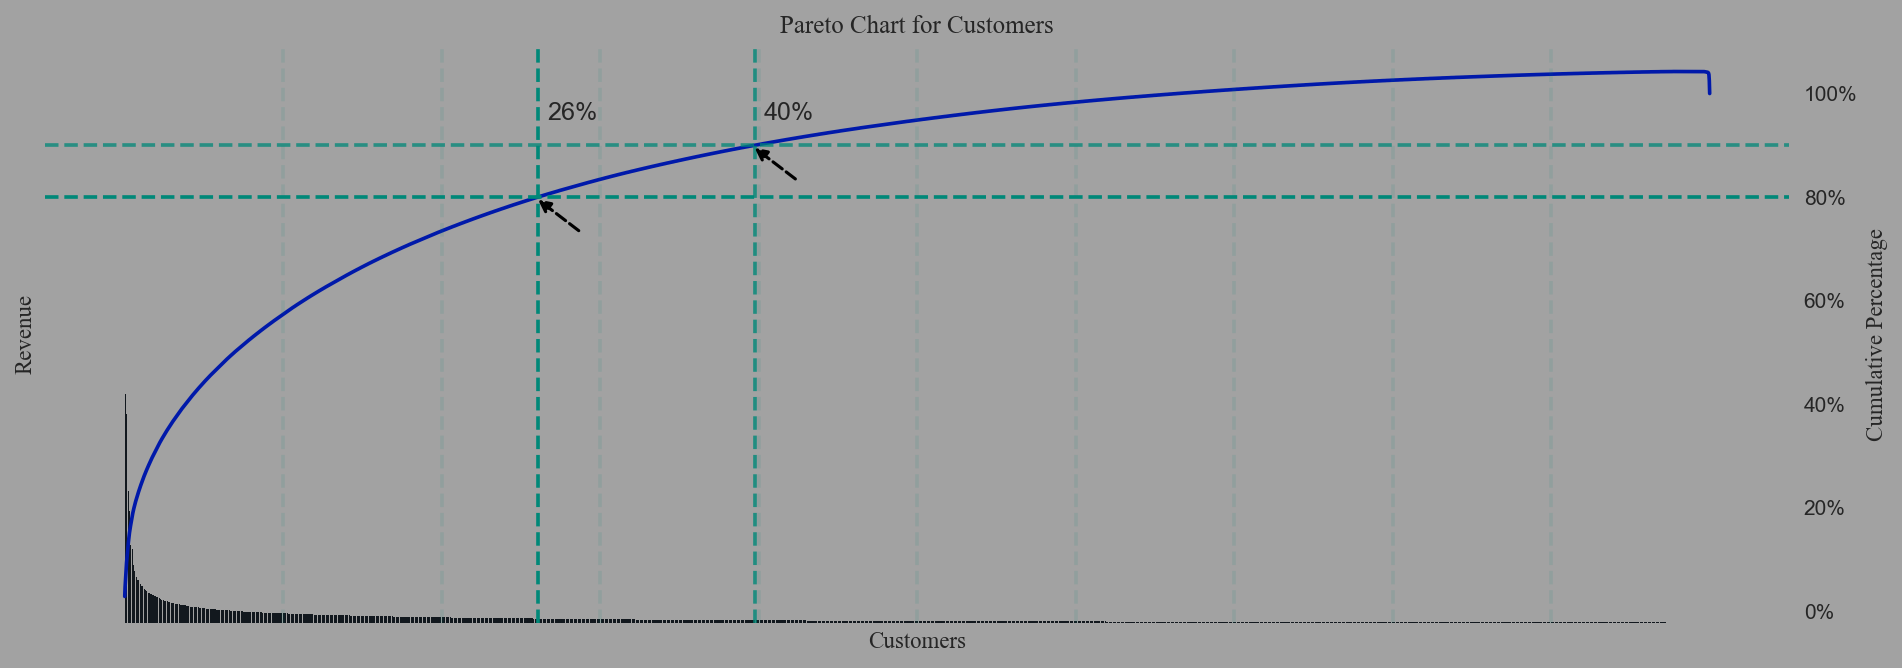

In [38]:
def create_pareto_plot(df, col, price, log=True):
    """Takes output from these data and visualizes it."""
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize=(15, 5), dpi=150, facecolor="#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log:
        sns.barplot(x=np.arange(len(df)), y=np.log(df[price]), ax=ax, color="#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
        ax.set_ylim(bottom=0)  # Ensure the log scale starts from 0
    else:
        sns.barplot(x=np.arange(len(df)), y=df[price], ax=ax, color="#101820")
        ax.set_ylabel("Revenue")
        ax.set_ylim(bottom=0)  # Start from 0 for a linear scale

    ax2 = ax.twinx()

    sns.lineplot(x=np.arange(len(df)), y=df.CumulativePercentage, ax=ax2, color="#0019AA")
    ax2.axhline(80, color="#008878", linestyle="dashed", alpha=1)
    ax2.axhline(90, color="#008878", linestyle="dashed", alpha=0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines:
        ax2.axvline(vline, color="#008878", linestyle="dashed", alpha=0.1)

    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color="#008878", linestyle="dashed", alpha=1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")

    prop = dict(arrowstyle="-|>", color="#000000", lw=1.5, ls="--")
    plt.annotate("", xy=(interaction_80 - 10, 80), xytext=(interaction_80 + 120, 73), arrowprops=prop)

    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color="#008878", linestyle="dashed", alpha=0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")
    plt.annotate("", xy=(interaction_90 - 10, 90), xytext=(interaction_90 + 120, 83), arrowprops=prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname="Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname="Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname="Times New Roman")
    ax.set_xlabel(subject, fontname="Times New Roman")
    sns.despine(left=True, right=True, bottom=True, top=True)
    plt.show()

create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = False)

/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


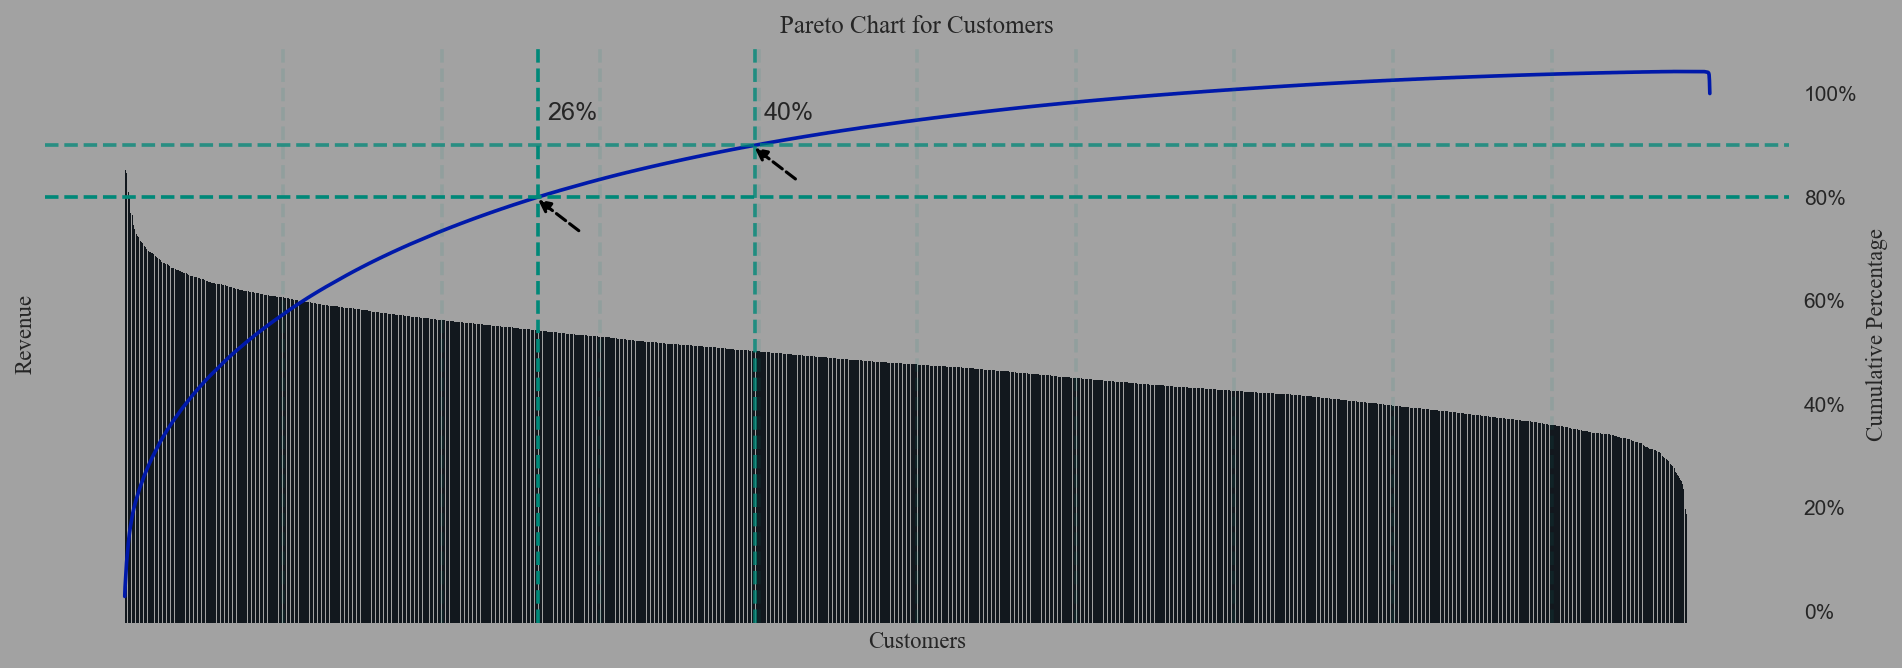

In [39]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = True)

We can see that 80% of company's revenue comes from top 26% of customers.

Also, 90% of company's revenue comes from top 40% of customers.

<a id="section-three-two"></a>

### 3.2) Pareto Chart for Products

In [40]:
item_price = prepare_pareto_data(df, "StockCode", "TotalPrice")
item_price.head(10)

,TotalPrice,CumulativePercentage
StockCode,,
22423,122752.60,1.80
POST,66710.24,2.78
85123A,61658.48,3.69
47566,60010.03,4.57
85099B,55398.06,5.38
22502,46980.95,6.07
84879,37347.62,6.62
79321,37114.57,7.16
22086,34176.88,7.67


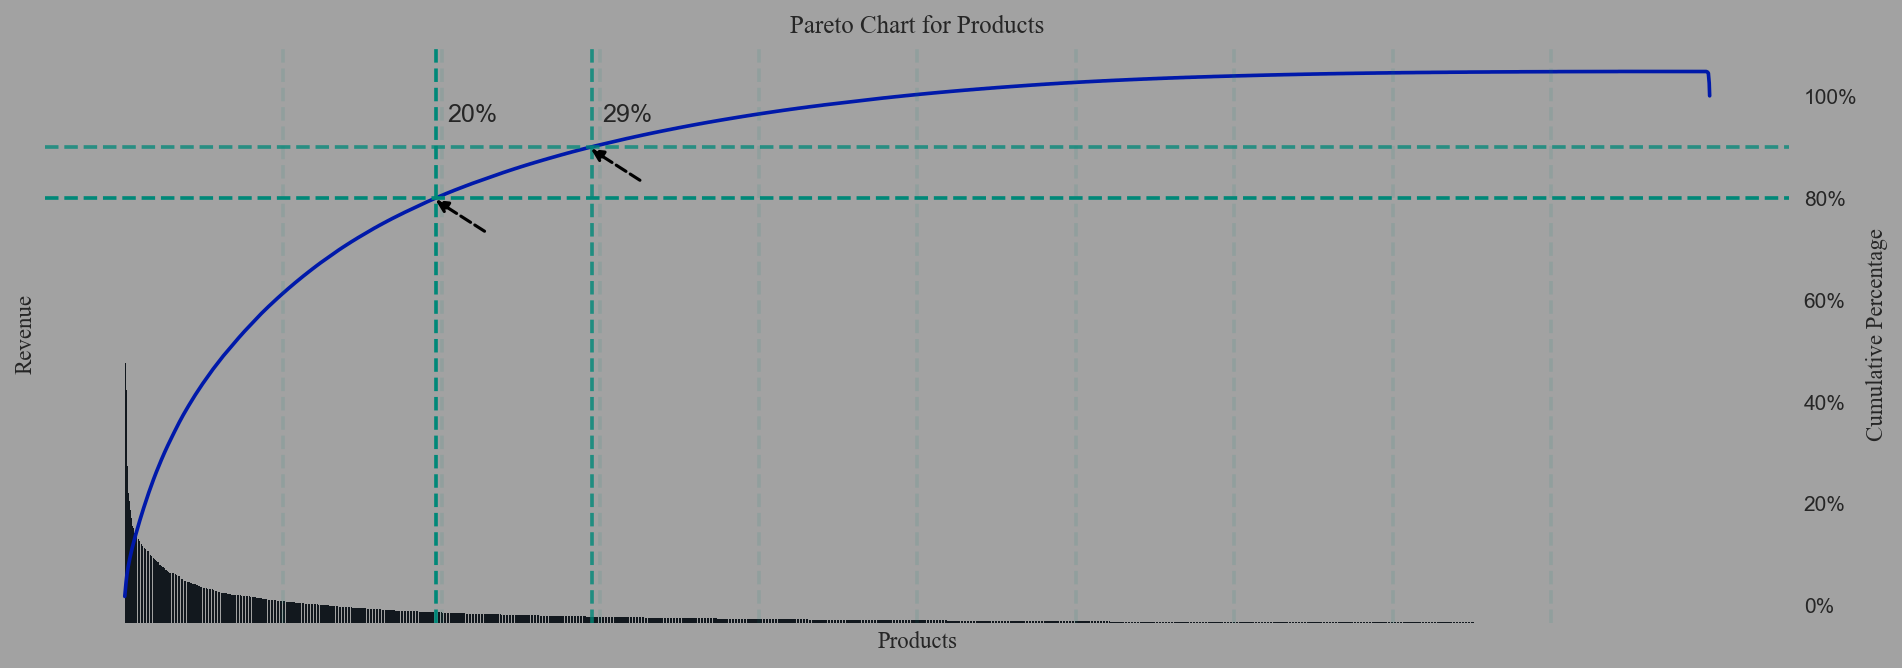

In [41]:
create_pareto_plot(item_price, "StockCode", "TotalPrice", log = False)

/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


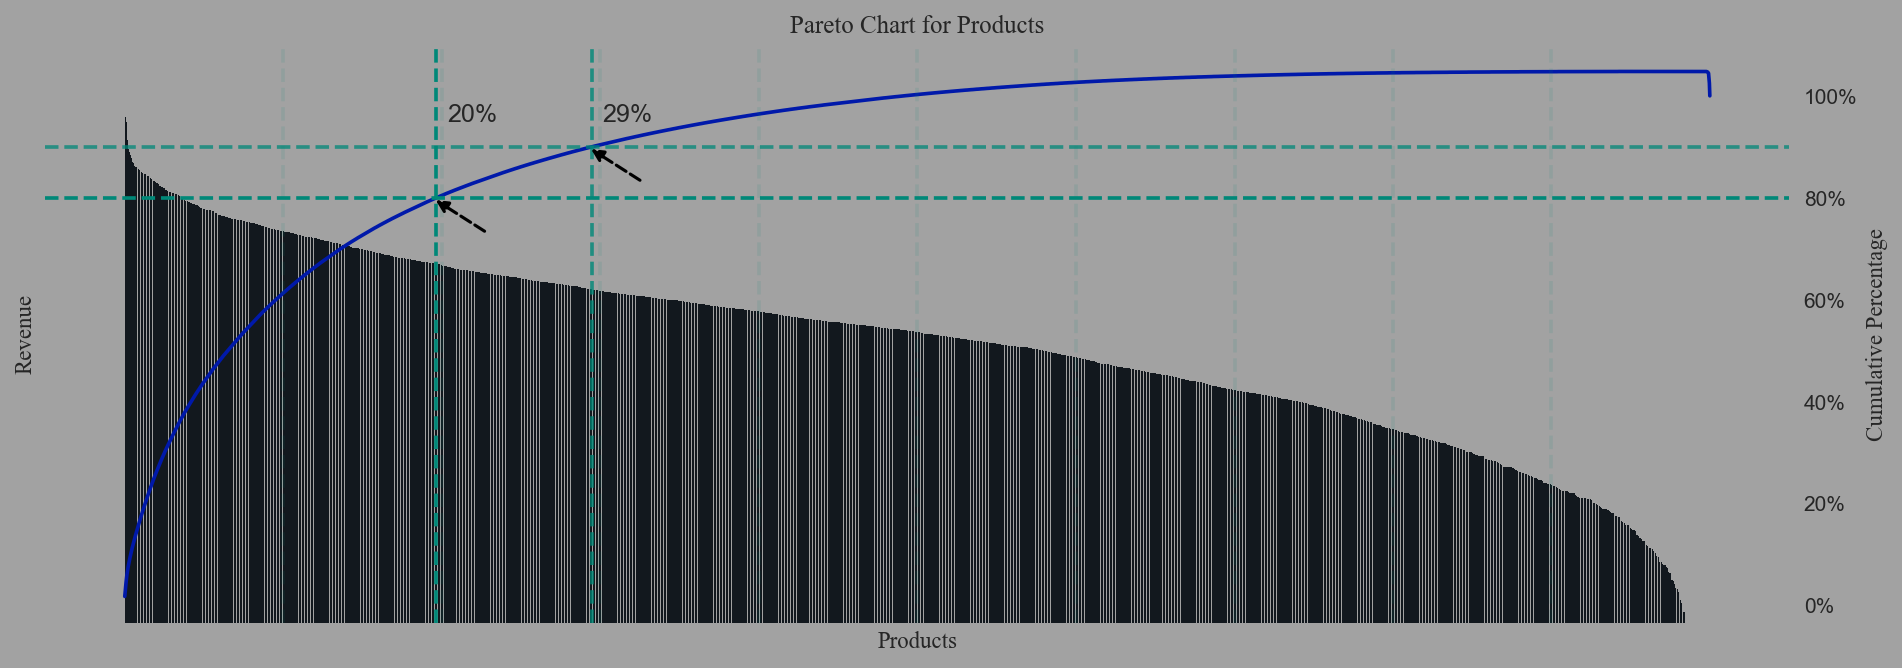

In [42]:
create_pareto_plot(item_price, "StockCode", "TotalPrice")

We can see that 80% of company's revenue comes from top 20% of products that have most revenue.

Also, 90% of company's revenue comes from 29% of products that have most revenue.

Maybe, if the company reduce by half its variety of items, revenue couldn't decrease significantly.

In [43]:
top_customers = customer_price[customer_price.CumulativePercentage <= 80].index.tolist()
products_for_top_customers = df[df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()
products_for_other_customers = df[~df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

## 4) RFM Analysis

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

**Recency**: How recently a customer has made a purchase

**Frequency**: How often a customer makes a purchase

**Monetary** Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

<a id="section-four-one"></a>

### 4.1) Preparing RFM Table

In [44]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))
last_day = df.InvoiceDate.max() + dt.timedelta(days = 1)

rfm_table = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                         "InvoiceNo": "nunique",
                                         "TotalPrice": "sum"})

rfm_table.rename(columns = {"InvoiceDate": "Recency",
                            "InvoiceNo": "Frequency",
                            "TotalPrice": "Monetary"}, inplace = True)

rfm_table.head()

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,-77183.60
12347.0,2,7,4060.40
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [45]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,-77183.60,1,1,1
12347.0,2,7,4060.40,5,4,5
12348.0,75,4,1797.24,2,4,4
12349.0,19,1,1757.55,4,1,4
12350.0,310,1,334.40,1,1,2


In [46]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,-77183.60,1,1,1,111,3
12347.0,2,7,4060.40,5,4,5,545,14
12348.0,75,4,1797.24,2,4,4,244,10
12349.0,19,1,1757.55,4,1,4,414,9
12350.0,310,1,334.40,1,1,2,112,4


<a id="section-four-two"></a>

### 4.2) RFM Segments

**Champions**: Bought recently, buy often and spend the most

**Loyal customers**: Buy on a regular basis. Responsive to promotions.

**Potential loyalist**: Recent customers with average frequency.

**Recent customers**: Bought most recently, but not often.

**Promising**: Recent shoppers, but haven’t spent much.

**Needs attention**: Above average recency, frequency and monetary values. May not have bought very recently though.

**About to sleep**: Below average recency and frequency. Will lose them if not reactivated.

**At risk**: Some time since they’ve purchased. Need to bring them back!

**Can’t lose them**: Used to purchase frequently but haven’t returned for a long time.

**Hibernating**: Last purchase was long back and low number of orders. May be lost.


In [47]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12346.0,326,1,-77183.60,1,1,1,111,3,Hibernating
12347.0,2,7,4060.40,5,4,5,545,14,Champions
12348.0,75,4,1797.24,2,4,4,244,10,At-Risk
12349.0,19,1,1757.55,4,1,4,414,9,Promising
12350.0,310,1,334.40,1,1,2,112,4,Hibernating


<a id="section-four-three"></a>

### 4.3) Visualizing RFM Grid

In [48]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

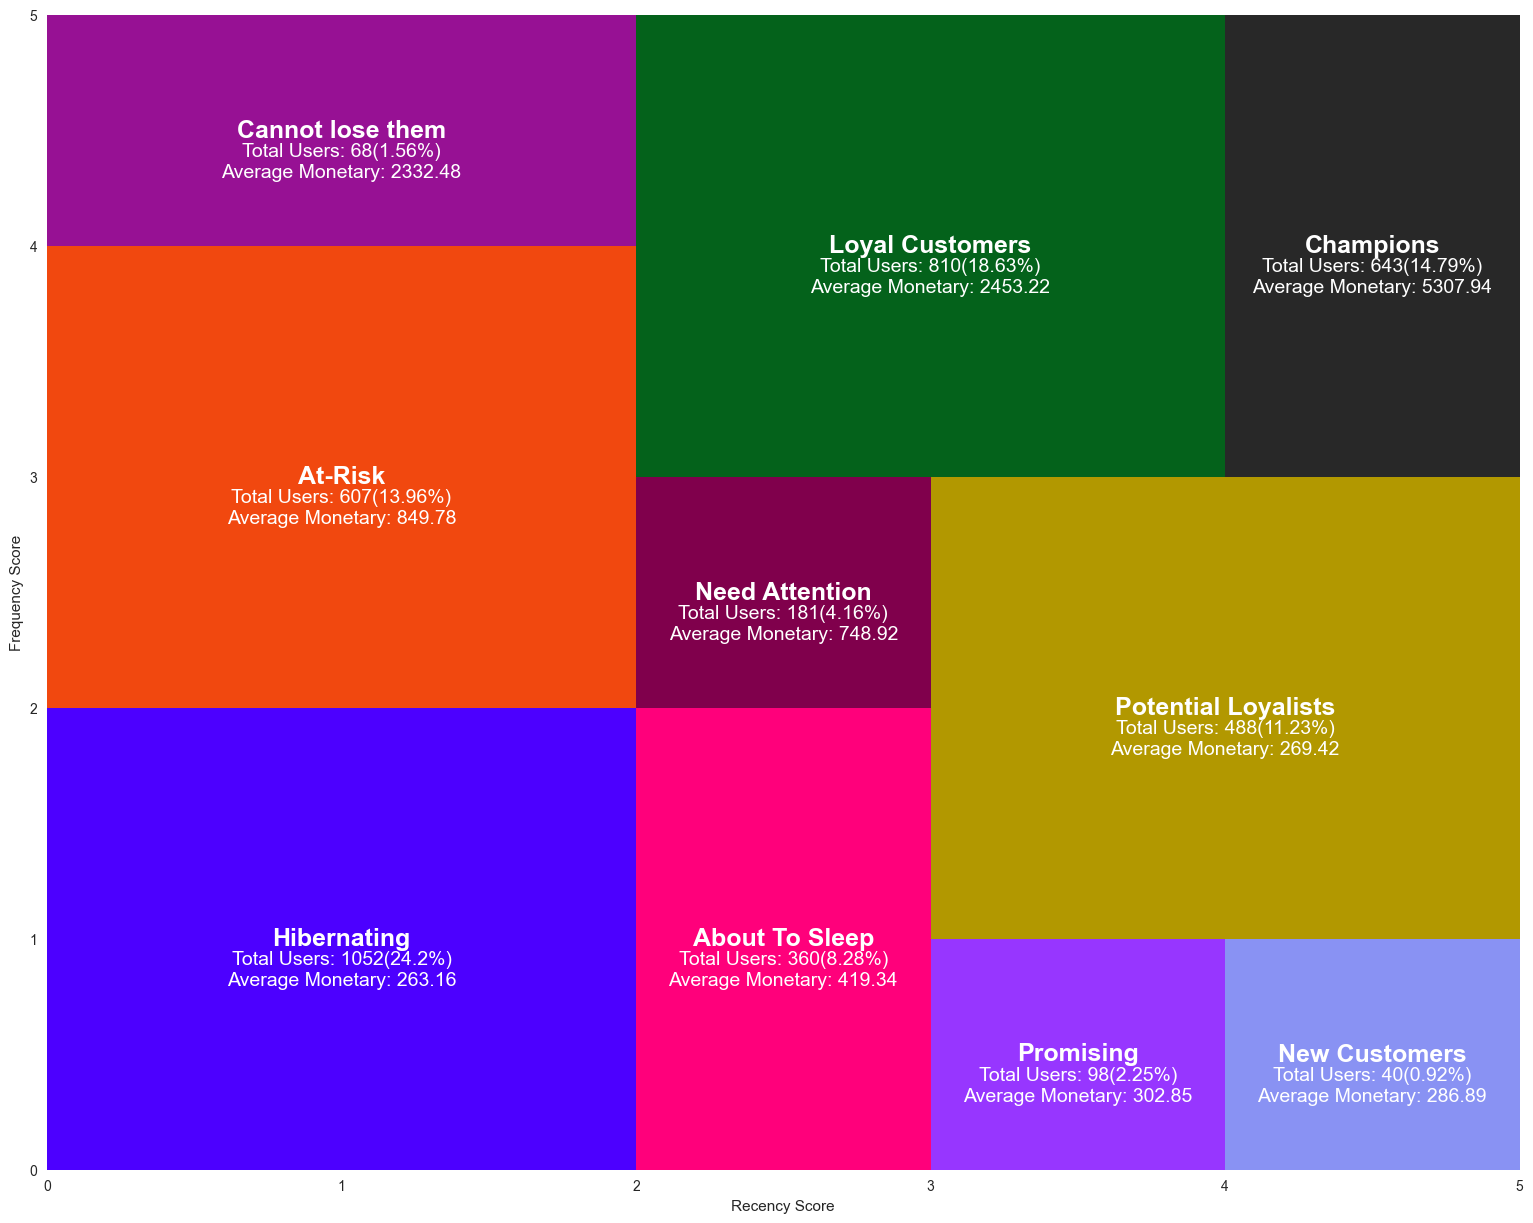

In [49]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

<a id="section-four-four"></a>

### 4.4) Visualizing RFM Segments

In [50]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)
rfm_monetary_size

,MeanMonetary,CustomerCount
Segment,,
Champions,5307.944992,643
Loyal Customers,2453.224680,810
Cannot lose them,2332.481765,68
At-Risk,849.775440,607
Need Attention,748.918785,181
About To Sleep,419.335111,360
Promising,302.846429,98
New Customers,286.894000,40
Potential Loyalists,269.421127,488


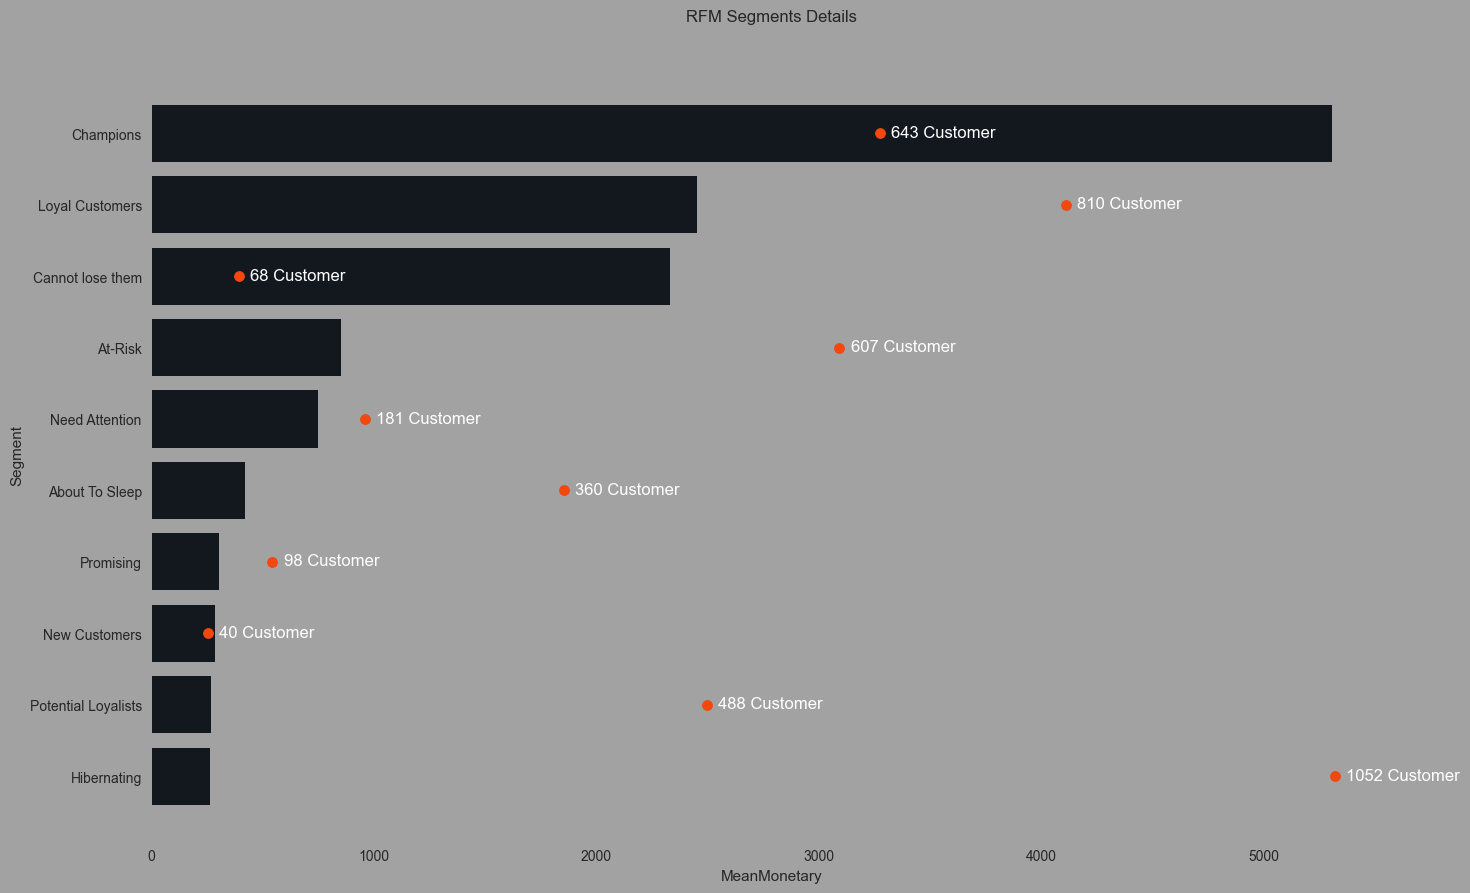

In [51]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanMonetary, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")


ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [52]:
rfm = rfm_table2.groupby("Segment").agg({"CustomerID": "nunique", 
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "Monetary": "mean"})
rfm.rename(columns = {"CustomerID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1).highlight_min(axis = 1, color = "#195190").highlight_max(axis = 1, color = "#D60000").format(precision=2)

Segment,About To Sleep,At-Risk,Cannot lose them,Champions,Hibernating,Loyal Customers,Need Attention,New Customers,Potential Loyalists,Promising
Segment Size,360.00,607.00,68.00,643.00,1052.00,810.00,181.00,40.00,488.00,98.00
Recency,52.29,158.46,133.09,5.39,216.99,32.04,49.31,6.65,16.26,22.62
Frequency,1.29,3.30,9.84,14.50,1.20,7.98,2.62,1.00,2.20,1.00
Monetary,419.34,849.78,2332.48,5307.94,263.16,2453.22,748.92,286.89,269.42,302.85


/tmp/ipykernel_20731/1553451640.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y),


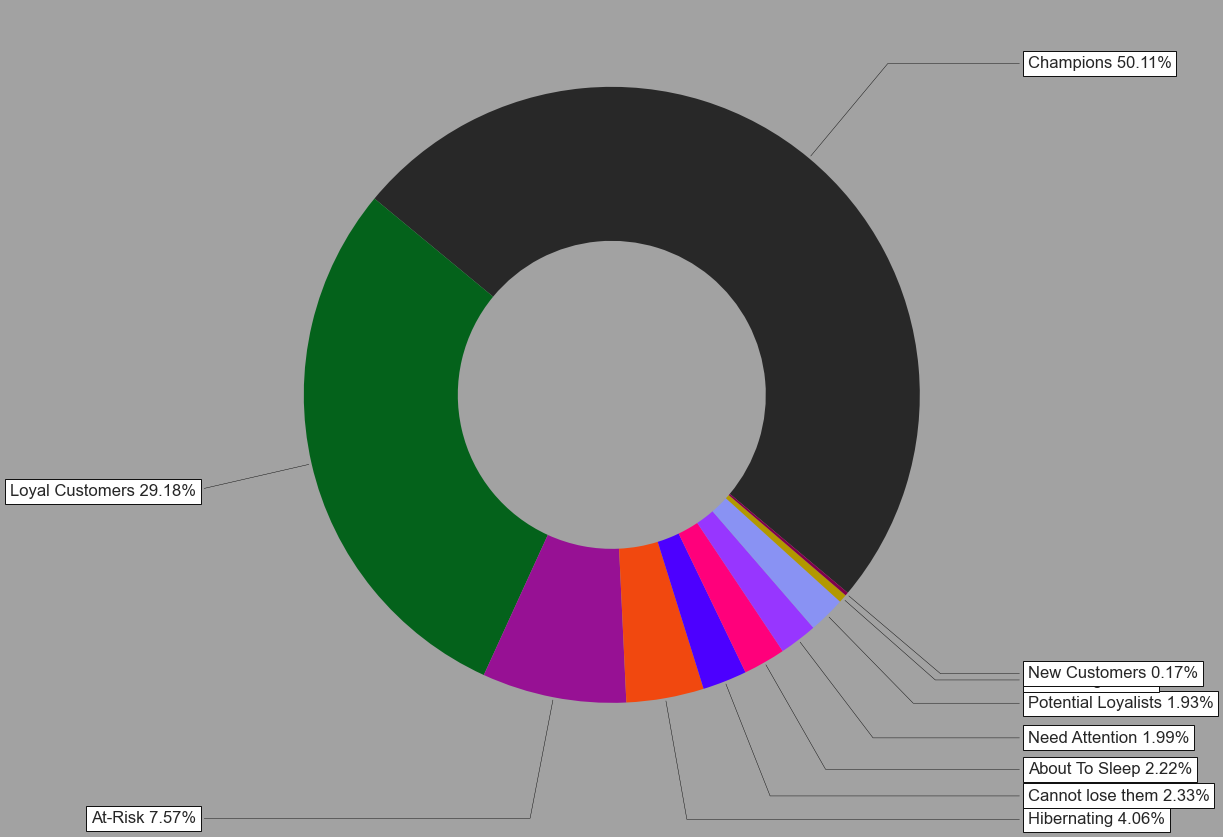

In [53]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, normalize=False, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

47.5% of total revenue comes from "Champions" segment, and 28% of total revenue comes from "Loyal Customers" segment. These two segments have 75% of company's total revenue.

In [54]:
# Select relevant columns
rfm_clustering = rfm_table2[["Recency", "Frequency", "Monetary", "Segment"]].copy()

# Apply log transformation and scaling
for col in ["Recency", "Frequency", "Monetary"]:
    scaler = StandardScaler()
    
    # Add a small constant to avoid log(0) issues
    rfm_clustering[col] = rfm_clustering[col].apply(lambda x: np.log(x + 1) if x >= 0 else np.nan)
    
    # Handle potential NaN values caused by negative inputs
    rfm_clustering[col].fillna(rfm_clustering[col].mean(), inplace=True)
    
    # Apply scaling
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1, 1))

# Melt the data for visualization
rfm_melted = pd.melt(
    rfm_clustering,
    id_vars="Segment",
    value_vars=["Recency", "Frequency", "Monetary"],
    var_name="RFM",
    value_name="Value"
)

# Output the cleaned and scaled data
rfm_melted.head()

/tmp/ipykernel_20731/3782384141.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_clustering[col].fillna(rfm_clustering[col].mean(), inplace=True)
/tmp/ipykernel_20731/3782384141.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

,Segment,RFM,Value
0,Hibernating,Recency,1.453323
1,Champions,Recency,-1.975654
2,At-Risk,Recency,0.386752
3,Promising,Recency,-0.589020
4,Hibernating,Recency,1.416655


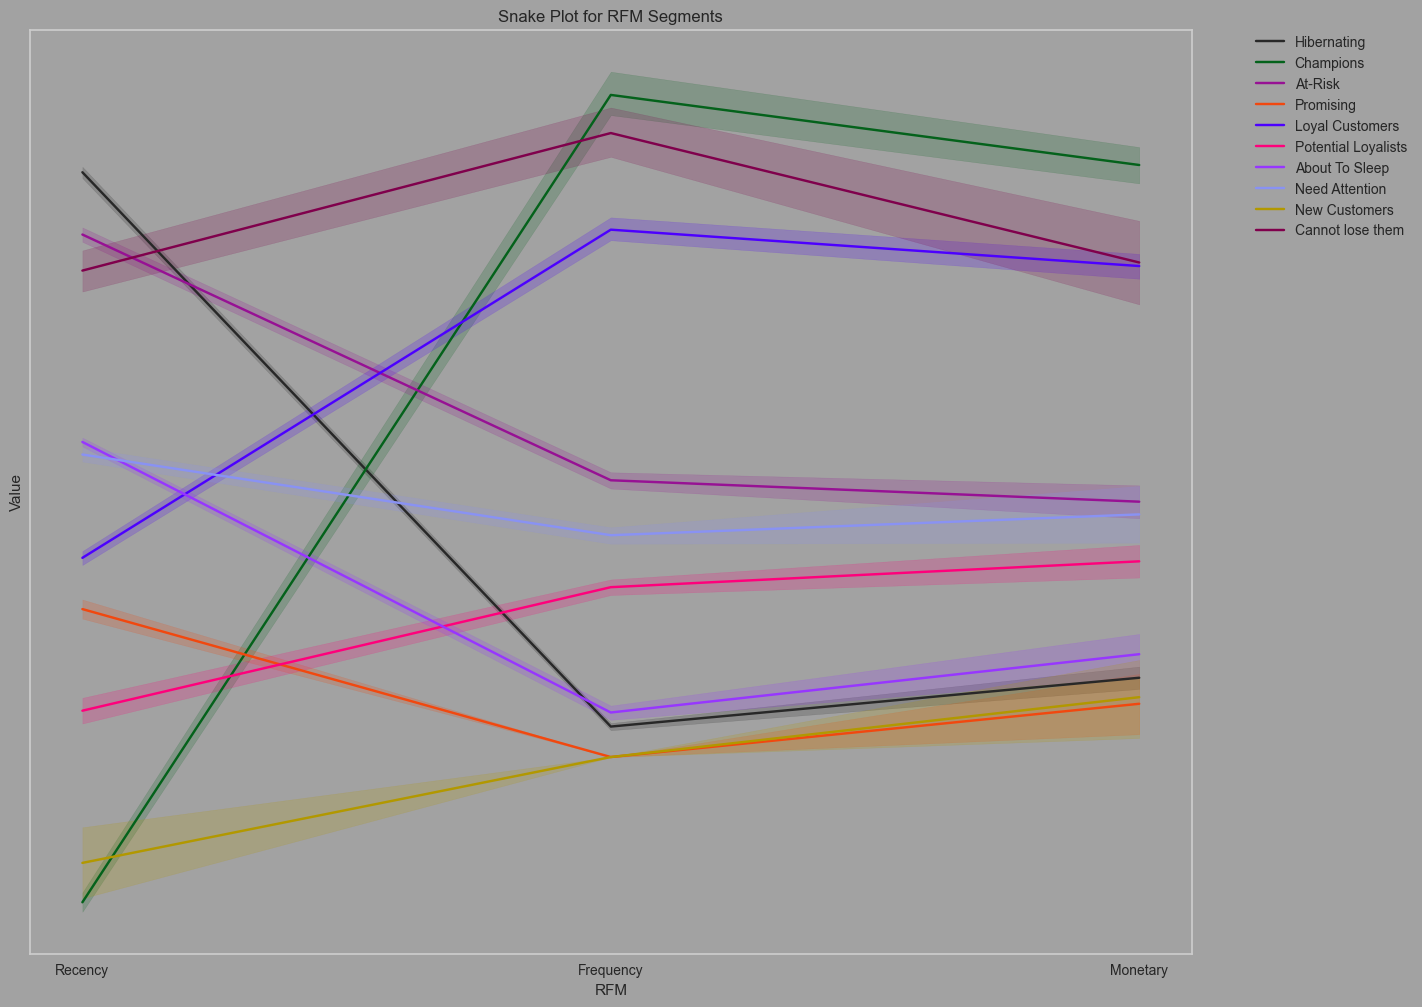

In [55]:
fig, ax = plt.subplots(figsize = (15, 12), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.lineplot(x = "RFM", y = "Value", hue = "Segment", data = rfm_melted, palette = palette)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments")
plt.show()

<a id="section-four-five"></a>

### 4.5) Customer Segmentation with using RFM Metrics

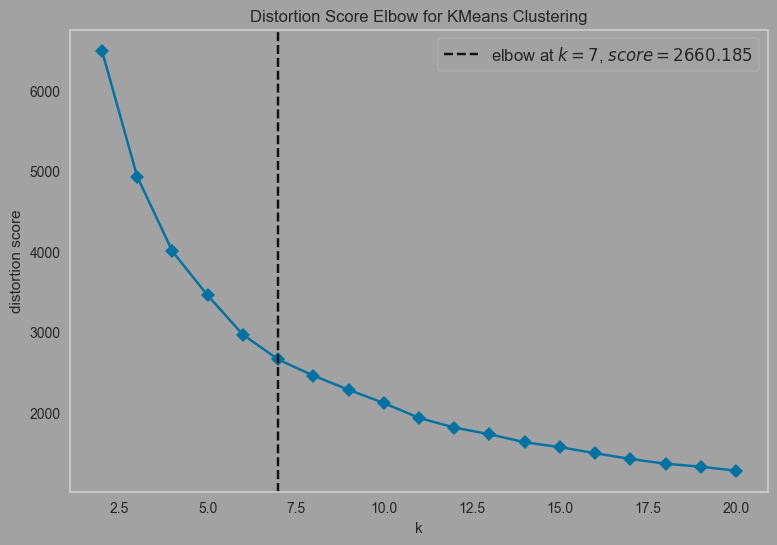

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
features = ["Recency", "Frequency", "Monetary"]

kmeans_ = KMeans(init = "k-means++", random_state = 42)

fig, ax = plt.subplots(figsize = (9, 6), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")
ax.grid(False)

visualizer = KElbowVisualizer(kmeans_, k = (2, 21), timings = False)

visualizer.fit(rfm_clustering[features]) 
visualizer.show()

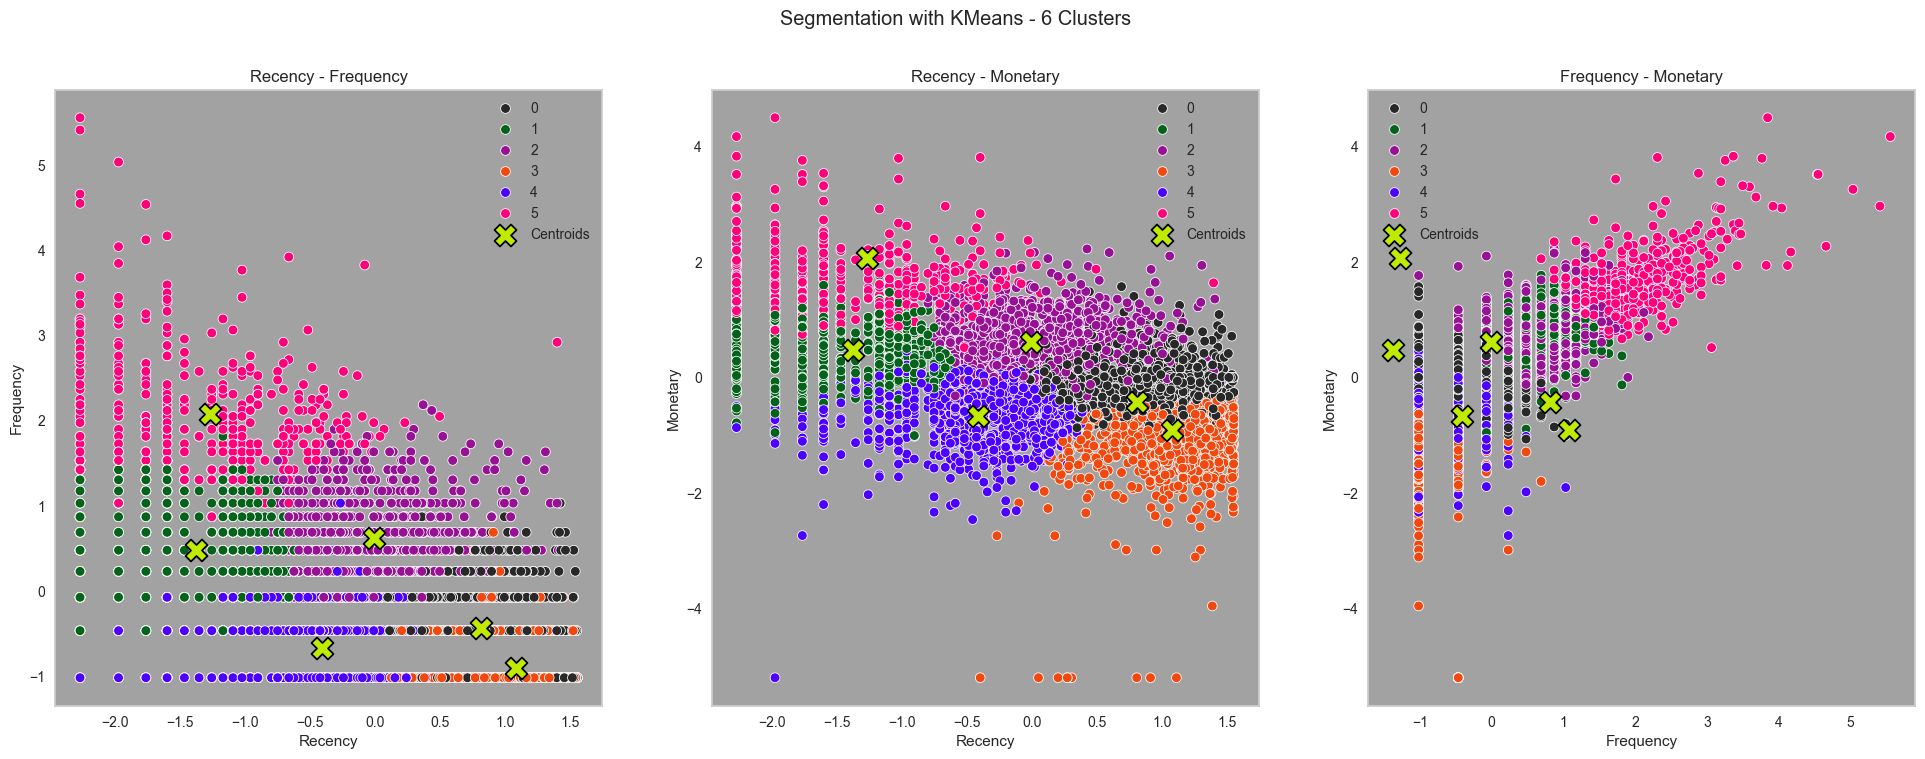

In [57]:
kmeans = KMeans(n_clusters = 6, random_state = 42) 
kmeans.fit(rfm_clustering[features])
cluster = kmeans.labels_

fig, axes = plt.subplots(1, 3, figsize = (24, 8))

for i, feature in list(enumerate(combinations(["Recency", "Frequency", "Monetary"], 2))):

    sns.scatterplot(x = rfm_clustering[feature[0]], y = rfm_clustering[feature[1]], hue = cluster, 
                    palette = palette[: len(set(cluster))], ax = axes[i]).set_title(feature[0] + " - " + feature[1])

    sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1],
                    s = 250, color = '#C0EB00', label = 'Centroids', marker = "X", ax = axes[i], edgecolor = "black")

plt.suptitle("Segmentation with KMeans - 6 Clusters")
for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.grid(False)
    
plt.show()

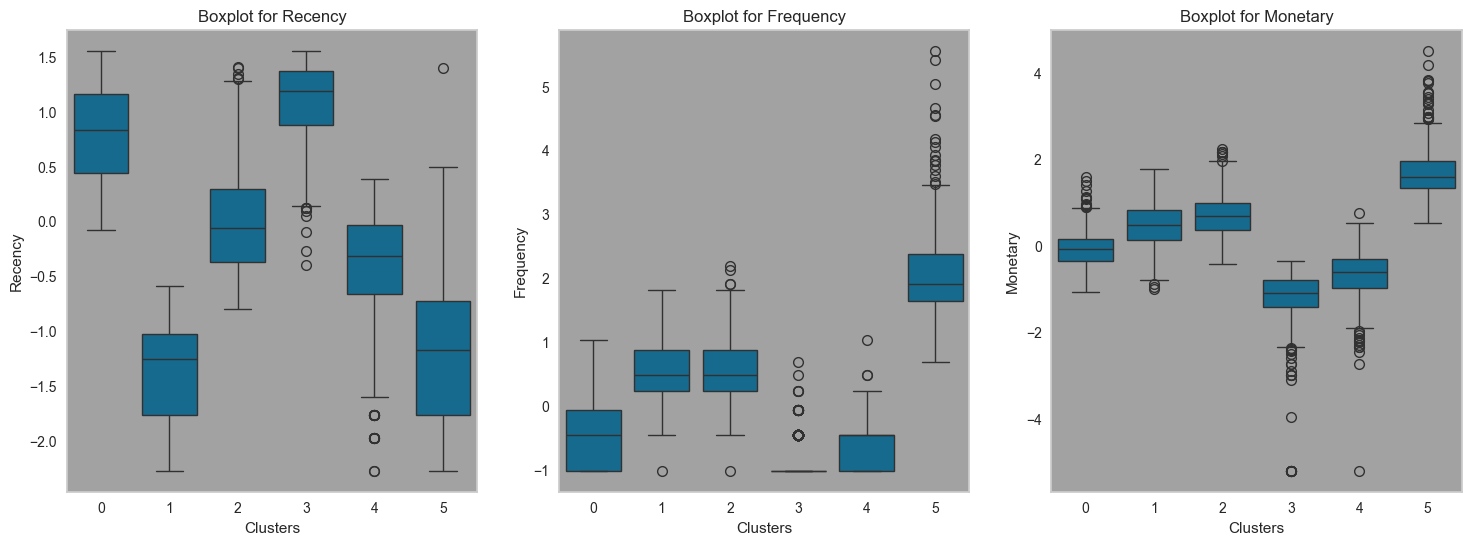

In [58]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.set_xlabel("Clusters")
    
sns.boxplot(x = cluster, y = "Recency", data = rfm_clustering, ax = axes[0]).set_title("Boxplot for Recency")
sns.boxplot(x = cluster, y = "Frequency", data = rfm_clustering, ax = axes[1]).set_title("Boxplot for Frequency")
sns.boxplot(x = cluster, y = "Monetary", data = rfm_clustering, ax = axes[2]).set_title("Boxplot for Monetary")

plt.show()

[take me to the top](#section-top)